In [ ]:
## load the packages

In [18]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hydrant.topology.geom as gm
import hydrant.topology.river_graph as rg
import subprocess
import os


In [19]:
# set the path to MERIT-Basins

In [20]:
# input paths
mb_path = '/Users/shg096/Desktop/MERIT_Hydro/cat/'
rv_path = '/Users/shg096/Desktop/MERIT_Hydro/riv/'

# output paths
path_out = './output/'

In [21]:
# preparing the target pfaf areas for manupulation

In [22]:
pfafs = ['71', '72']

# Define the file name templates with a placeholder *
cat_file_template = 'cat_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'
riv_file_template = 'riv_pfaf_*_MERIT_Hydro_v07_Basins_v01_bugfix1.shp'

cat_files = []
riv_files = []

for pafaf in pfafs:
    # Replace * with the current pafaf value
    cat_files.append(cat_file_template.replace('*', pafaf))
    riv_files.append(riv_file_template.replace('*', pafaf))

# reading in data and append
cat = pd.concat([gpd.read_file(os.path.join(mb_path, f)) for f in cat_files])
riv = pd.concat([gpd.read_file(os.path.join(rv_path, f)) for f in riv_files])

cat.set_crs(epsg=4326, inplace=True, allow_override=True)
riv.set_crs(epsg=4326, inplace=True, allow_override=True)


,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
0,71000001,7.020492,4.158236,1.688334,0.000570,391.901537,2,0.0,0.000000,71000065,2,71000095,71000213,0,0,"LINESTRING (-98.06167 60.00000, -98.06250 59.9..."
1,71000002,24.171249,15.709184,1.538670,0.000058,701.754912,2,1.4,0.000058,71000065,2,71000003,71000014,0,0,"LINESTRING (-98.06167 60.00000, -98.06083 60.0..."
2,71000003,14.760464,11.209022,1.316838,0.000770,480.760660,2,11.4,0.000770,71000002,2,71000004,71000011,0,0,"LINESTRING (-98.17250 60.13000, -98.17333 60.1..."
3,71000004,6.240078,4.631999,1.347168,0.000911,388.938962,2,5.7,0.000911,71000003,2,71000005,71000015,0,0,"LINESTRING (-98.33500 60.07000, -98.33583 60.0..."
4,71000005,4.462477,3.338111,1.336827,0.000670,328.557527,2,3.0,0.000670,71000004,2,71000006,71000012,0,0,"LINESTRING (-98.39917 60.09667, -98.40000 60.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59785,72059786,8.235011,6.125759,1.344325,0.008896,51.578512,1,73.3,0.008896,72057890,0,0,0,0,0,"LINESTRING (-81.56917 41.20250, -81.57000 41.2..."
59786,72059787,0.881055,0.648637,1.358317,0.000000,28.659389,1,0.0,0.000000,72058076,0,0,0,0,0,"LINESTRING (-84.77500 41.24333, -84.77417 41.2..."
59787,72059788,0.001115,0.001115,1.000000,0.000000,28.138533,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (-72.38500 61.88750, -72.38500 61.8..."
59788,72059789,0.001111,0.001111,1.000000,10.799241,26.348979,1,0.0,0.000000,0,0,0,0,0,0,"LINESTRING (-55.38917 47.21667, -55.38917 47.2..."


<Axes: >

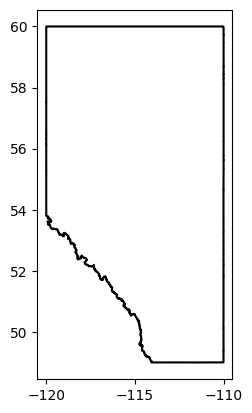

In [23]:
# Manupulate target shapefile if desired or exists (this is optional)
trg_shp = gpd.read_file('/Users/shg096/Downloads/lpr_000b16a_e/lpr_000b16a_e.shp')
sel_pr = ['Quebec', 'New Brunswick', 'Nova Scotia', 'Prince Edward Island']
sel_pr = ['Nova Scotia', 'Prince Edward Island']
sel_pr = ['Alberta']
# subsetting `provinces` variable
trg_provinces = trg_shp.loc[trg_shp.PRENAME.isin(sel_pr)].copy().to_crs(epsg=4326)
trg_provinces.boundary.plot(color='k')

In [24]:
cat, riv = gm.intersect_topology(cat=cat,\
                                 cat_cols={'id':'COMID'},\
                                 riv=riv,\
                                 riv_cols={'id':'COMID', 'next_id':'NextDownID'},\
                                 shapefile=trg_provinces)



In [15]:
def get_segment(riv,
                station_info,
                riv_col_seg,
                station_col_name = {'lat':'lat', 'lon':'lon', 'up_area':'up_area'},
                riv_col_up_area = None,
                riv_scale_up_area = None, # km2 to m2
                station_scale_up_area = None, # km2 to m2
                tolerance_for_area_diff = 0.05):

    # 
    if riv_col_up_area is not None:
        if riv_scale_up_area is not None:
            riv[riv_col_up_area] = riv[riv_col_up_area]*riv_scale_up_area

    # rename station
    station_info = station_info.rename(columns=station_col_name)

    if station_scale_up_area is not None:
        station_info.loc ['up_area'] = station_info.loc ['up_area'] * station_scale_up_area

    # 
    riv['lat_centroid'] = riv.centroid.y
    riv['lon_centroid'] = riv.centroid.x

    station_info['seg_id'] = np.NaN
    # loop over the station_info get the lat and lon and if available upstream area
    for index, row in station_info.iterrows():
        riv_temp = riv.copy()
        riv_temp['dist'] = 0
        riv_temp['dist'] = (riv['lat_centroid']-row['lat'])**2 + (riv['lon_centroid']-row['lon'])**2
        if (tolerance_for_area_diff is not None) and (riv_col_up_area is not None) and ('up_area' in station_col_name.keys()):
            riv_temp['area_within'] = riv_temp[riv_col_up_area].abs()/row.up_area.item()
            riv_temp = riv_temp [riv_temp ['area_within'] < tolerance_for_area_diff]
        if not riv_temp.empty(): # pass Nan
            riv_temp = riv_temp.sort_values(by='dist')
            riv_temp = riv_temp.reset_index(drop=True)
            station_info['seg_id'] = riv_temp[riv_col_seg].iloc[0]
        
    

1030

In [17]:
riv

,COMID,lengthkm,lengthdir,sinuosity,slope,uparea,order,strmDrop_t,slope_taud,NextDownID,maxup,up1,up2,up3,up4,geometry
40417,72040418,7.930461,6.518053,1.216692,0.000101,1163.992236,3,0.8,0.000101,-9999,2,72040441,72043164,0,0,"LINESTRING (-61.11083 46.44083, -61.11000 46.4..."
40440,72040441,6.613930,5.755998,1.149050,0.000665,1059.860742,3,4.4,0.000665,72040418,2,72040518,72041349,0,0,"LINESTRING (-61.07833 46.38667, -61.07833 46.3..."
40517,72040518,15.793813,11.320412,1.395162,0.002322,485.289741,2,36.7,0.002322,72040441,2,72047652,72050768,0,0,"LINESTRING (-61.09250 46.33583, -61.09333 46.3..."
41348,72041349,6.029933,4.659766,1.294042,0.001772,554.437391,2,10.7,0.001772,72040441,2,72041383,72042754,0,0,"LINESTRING (-61.09250 46.33583, -61.09250 46.3..."
41382,72041383,2.361885,1.685364,1.401409,0.001522,486.832435,2,3.6,0.001522,72041349,2,72041533,72042797,0,0,"LINESTRING (-61.03583 46.32083, -61.03583 46.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57591,72057592,9.125046,5.160018,1.768413,0.003110,59.038380,1,28.4,0.003110,-9999,0,0,0,0,0,"LINESTRING (-65.76667 43.67250, -65.76667 43.6..."
57639,72057640,21.215053,12.312460,1.723056,0.001159,83.168250,1,24.6,0.001159,-9999,0,0,0,0,0,"LINESTRING (-65.34917 43.60000, -65.35000 43.6..."
57674,72057675,1.379980,1.053919,1.309380,0.001160,51.268208,1,1.6,0.001160,-9999,0,0,0,0,0,"LINESTRING (-65.77750 43.69833, -65.77750 43.6..."
57684,72057685,0.877303,0.844651,1.038658,0.014818,31.769563,1,0.0,0.000000,-9999,0,0,0,0,0,"LINESTRING (-66.03250 43.71083, -66.03250 43.7..."


In [ ]:
region_catchments, region_rivers = gm.intersect_topology(cat=catchments, cat_cols={'id':'COMID'}, riv=rivers, riv_cols={'id':'COMID', 'next_id':'NextDownID'}, shapefile=qc_maritimes)